<a href="https://colab.research.google.com/github/VIS-WA/custom-image-similarity-faiss/blob/main/image_similarity_faiss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building an image similarity system with 🤗, Custom Datasets and FAISS

This notebook is adapted from HuggingFace's [Image Similarity with 🤗 Datasets and 🤗 Transformers](https://huggingface.co/blog/image-similarity) blog post. The original notebook can be found [here](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/image_similarity.ipynb#scrollTo=fAYCqp0Ufx_V). This notebook is modified to work with custom datasets and intended for beginners to learn how to build an image similarity system with 🤗, custom datasets and FAISS.


## Install the required packages


In [1]:
!pip install --upgrade pip
!pip install transformers datasets faiss-cpu -q


  Using cached pip-24.3.1-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
C:\Users\ssoun\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip show transformers 

Name: transformers
Version: 4.36.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: c:\users\ssoun\appdata\local\programs\python\python310\lib\site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: groundingdino
Note: you may need to restart the kernel to use updated packages.


## Import the necessary packages

In [3]:
from transformers import AutoFeatureExtractor, AutoModel
from datasets import load_dataset, concatenate_datasets, load_from_disk, DatasetDict, Features, Dataset
from PIL import Image
import numpy as np

In [6]:
import timm

model = timm.create_model('efficientnet_b1', pretrained=True)
model.eval()

model.safetensors:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

C:\Users\ssoun\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ssoun\.cache\huggingface\hub\models--timm--efficientnet_b1.ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
      

In [7]:
extractor = AutoFeatureExtractor.from_pretrained(model)


OSError: Incorrect path_or_model_id: 'EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
      (1): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(16, 4, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
        (conv_pw): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (conv_dw): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=96, bias=False)
        (bn2): BatchNormAct2d(
          96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(96, 4, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(4, 96, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pwl): Conv2d(96, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNormAct2d(
          24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
      (1): InvertedResidual(
        (conv_pw): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (conv_dw): Conv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=144, bias=False)
        (bn2): BatchNormAct2d(
          144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(144, 6, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(6, 144, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pwl): Conv2d(144, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNormAct2d(
          24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
      (2): InvertedResidual(
        (conv_pw): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (conv_dw): Conv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=144, bias=False)
        (bn2): BatchNormAct2d(
          144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(144, 6, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(6, 144, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pwl): Conv2d(144, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNormAct2d(
          24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (2): Sequential(
      (0): InvertedResidual(
        (conv_pw): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (conv_dw): Conv2d(144, 144, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), groups=144, bias=False)
        (bn2): BatchNormAct2d(
          144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(144, 6, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(6, 144, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pwl): Conv2d(144, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNormAct2d(
          40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
      (1): InvertedResidual(
        (conv_pw): Conv2d(40, 240, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (conv_dw): Conv2d(240, 240, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=240, bias=False)
        (bn2): BatchNormAct2d(
          240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(240, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 240, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pwl): Conv2d(240, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNormAct2d(
          40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
      (2): InvertedResidual(
        (conv_pw): Conv2d(40, 240, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (conv_dw): Conv2d(240, 240, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=240, bias=False)
        (bn2): BatchNormAct2d(
          240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(240, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 240, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pwl): Conv2d(240, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNormAct2d(
          40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (3): Sequential(
      (0): InvertedResidual(
        (conv_pw): Conv2d(40, 240, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (conv_dw): Conv2d(240, 240, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=240, bias=False)
        (bn2): BatchNormAct2d(
          240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(240, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 240, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pwl): Conv2d(240, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNormAct2d(
          80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
      (1): InvertedResidual(
        (conv_pw): Conv2d(80, 480, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (conv_dw): Conv2d(480, 480, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=480, bias=False)
        (bn2): BatchNormAct2d(
          480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(480, 20, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(20, 480, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pwl): Conv2d(480, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNormAct2d(
          80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
      (2): InvertedResidual(
        (conv_pw): Conv2d(80, 480, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (conv_dw): Conv2d(480, 480, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=480, bias=False)
        (bn2): BatchNormAct2d(
          480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(480, 20, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(20, 480, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pwl): Conv2d(480, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNormAct2d(
          80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
      (3): InvertedResidual(
        (conv_pw): Conv2d(80, 480, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (conv_dw): Conv2d(480, 480, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=480, bias=False)
        (bn2): BatchNormAct2d(
          480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(480, 20, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(20, 480, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pwl): Conv2d(480, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNormAct2d(
          80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (4): Sequential(
      (0): InvertedResidual(
        (conv_pw): Conv2d(80, 480, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (conv_dw): Conv2d(480, 480, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=480, bias=False)
        (bn2): BatchNormAct2d(
          480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(480, 20, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(20, 480, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pwl): Conv2d(480, 112, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNormAct2d(
          112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
      (1): InvertedResidual(
        (conv_pw): Conv2d(112, 672, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          672, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (conv_dw): Conv2d(672, 672, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=672, bias=False)
        (bn2): BatchNormAct2d(
          672, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(672, 28, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(28, 672, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pwl): Conv2d(672, 112, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNormAct2d(
          112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
      (2): InvertedResidual(
        (conv_pw): Conv2d(112, 672, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          672, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (conv_dw): Conv2d(672, 672, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=672, bias=False)
        (bn2): BatchNormAct2d(
          672, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(672, 28, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(28, 672, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pwl): Conv2d(672, 112, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNormAct2d(
          112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
      (3): InvertedResidual(
        (conv_pw): Conv2d(112, 672, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          672, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (conv_dw): Conv2d(672, 672, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=672, bias=False)
        (bn2): BatchNormAct2d(
          672, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(672, 28, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(28, 672, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pwl): Conv2d(672, 112, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNormAct2d(
          112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (5): Sequential(
      (0): InvertedResidual(
        (conv_pw): Conv2d(112, 672, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          672, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (conv_dw): Conv2d(672, 672, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), groups=672, bias=False)
        (bn2): BatchNormAct2d(
          672, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(672, 28, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(28, 672, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pwl): Conv2d(672, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNormAct2d(
          192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
      (1): InvertedResidual(
        (conv_pw): Conv2d(192, 1152, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          1152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (conv_dw): Conv2d(1152, 1152, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=1152, bias=False)
        (bn2): BatchNormAct2d(
          1152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(1152, 48, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(48, 1152, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pwl): Conv2d(1152, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNormAct2d(
          192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
      (2): InvertedResidual(
        (conv_pw): Conv2d(192, 1152, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          1152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (conv_dw): Conv2d(1152, 1152, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=1152, bias=False)
        (bn2): BatchNormAct2d(
          1152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(1152, 48, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(48, 1152, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pwl): Conv2d(1152, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNormAct2d(
          192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
      (3): InvertedResidual(
        (conv_pw): Conv2d(192, 1152, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          1152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (conv_dw): Conv2d(1152, 1152, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=1152, bias=False)
        (bn2): BatchNormAct2d(
          1152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(1152, 48, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(48, 1152, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pwl): Conv2d(1152, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNormAct2d(
          192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
      (4): InvertedResidual(
        (conv_pw): Conv2d(192, 1152, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          1152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (conv_dw): Conv2d(1152, 1152, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=1152, bias=False)
        (bn2): BatchNormAct2d(
          1152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(1152, 48, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(48, 1152, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pwl): Conv2d(1152, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNormAct2d(
          192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (6): Sequential(
      (0): InvertedResidual(
        (conv_pw): Conv2d(192, 1152, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          1152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (conv_dw): Conv2d(1152, 1152, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1152, bias=False)
        (bn2): BatchNormAct2d(
          1152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(1152, 48, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(48, 1152, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pwl): Conv2d(1152, 320, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNormAct2d(
          320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
      (1): InvertedResidual(
        (conv_pw): Conv2d(320, 1920, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          1920, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (conv_dw): Conv2d(1920, 1920, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1920, bias=False)
        (bn2): BatchNormAct2d(
          1920, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(1920, 80, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(80, 1920, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pwl): Conv2d(1920, 320, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNormAct2d(
          320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
  )
  (conv_head): Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn2): BatchNormAct2d(
    1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (global_pool): SelectAdaptivePool2d(pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
  (classifier): Linear(in_features=1280, out_features=1000, bias=True)
)'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [15]:
model_ckpt = "facebook/deit-small-patch16-224"

# Load the feature extractor
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

hidden_dim = model.config.hidden_size

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

C:\Users\ssoun\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ssoun\.cache\huggingface\hub\models--facebook--deit-small-patch16-224. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

C:\Users\ssoun\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/88.3M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at facebook/deit-small-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Load model for computing embeddings of the candidate images

In [17]:
model_ckpt = "google/vit-base-patch16-224"

extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

hidden_dim = model.config.hidden_size

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
import cv2
import os
import jsonlines


In [4]:
image = cv2.imread("D://Autility//image-similarity//Plan2.png")
output_dir = "D://Autility//image-similarity//patches_train"
# image = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)
height, width = image.shape[:2]
data = []
patch_size=224
overlap=0.5
init = 0

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Calculate overlap size in pixels
overlap_pixels = int(patch_size * overlap)
# Generate patches with overlap
for y in range(0, height-patch_size+1, patch_size - overlap_pixels):
    for x in range(0, width-patch_size+1, patch_size - overlap_pixels):
        patch = image[y:y+patch_size, x:x+patch_size]            
        # patch_dict[("patch_" + str(y) + "_" + str(x))] = {
        #     'top_left': (x, y),
        #     'top_right': (x + patch_size, y),
        #     'bottom_left': (x, y + patch_size),
        #     'bottom_right': (x + patch_size, y + patch_size)
        # }
        patch_json = {"file_name": "patch_" + str(init) + ".jpg",  
                      "coords" : [(x, y), (x + patch_size, y + patch_size)]}
        data.append(patch_json)
        patch_filename = os.path.join(output_dir, "patch_" + str(init) + ".jpg")
        cv2.imwrite(patch_filename, patch)

        init += 1

json_file_path = os.path.join(output_dir, 'metadata.jsonl')
with jsonlines.open(json_file_path, mode='w') as writer:
    writer.write_all(data)

## Load candidate subset

1. Prepare your dataset of Images in the following format:

```
train
├── class1
│   ├── 1.jpg
│   ├── 2.jpg
│   └── 3.jpg
|   ...
├── class2
│   ├── 1.jpg
│   ├── 2.jpg
│   └── 3.jpg
|   ...
└── class3
    ├── 1.jpg
    ├── 2.jpg
    └── 3.jpg
    ...
```
Here, the name of the class1 can be anything and the name of the images can be anything. The only requirement is that the images should be in the ```jpg``` format. These class names would later reflect in the labels of the identified images.
2. Place the ```train``` folder in your Google Drive.

In [8]:
dataset = load_dataset("imagefolder", data_dir="D://Sounok//Similar_objects_in_image//patches_train")
candidate_dataset = dataset['train']

Resolving data files:   0%|          | 0/4347 [00:00<?, ?it/s]

In [14]:
print(candidate_dataset[0]['name'])

KeyError: 'name'

In [10]:
print(dataset["train"].features)

{'image': Image(decode=True, id=None), 'coords': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None)}


## Resize the images (OPTIONAL, if required)

In [33]:
# resize all PIL images to 224x224
for i, example in enumerate(candidate_dataset):
    candidate_dataset[i]['image'] = example['image'].resize((224, 224), Image.BILINEAR)

In [71]:
test_image = candidate_dataset[1]
print(test_image)
test_image['image'].save("Test1.jpg") 
# candidate_dataset.features['labels']

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x1E3ADC08790>}


In [34]:
# labels to names mapping for visualization purposes
folder_names = candidate_dataset.features['label'].names

# assign labels to the images from the folder names
labels_to_names = {i: folder_names[i] for i in range(len(folder_names))}


KeyError: 'label'

## Extract embeddings

In [10]:
def extract_embeddings(image):
    image_pp = extractor(image, return_tensors="pt")
    features = model(**image_pp).last_hidden_state[:, 0].detach().numpy()
    return features.squeeze()

## Creating hashes for the embeddings using FAISS and saving the index

In [16]:

dataset_with_embeddings = candidate_dataset.map(lambda example: {'embeddings': extract_embeddings(example["image"])})

# save dataset with embeddings variable to disk
dataset_with_embeddings.save_to_disk('old_embeddings')

# load dataset with embeddings from disk
dataset_with_embeddings.add_faiss_index(column='embeddings')

# save the faiss index to disk
dataset_with_embeddings.save_faiss_index('embeddings', 'old_index.faiss')


Map:   0%|          | 0/4346 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4346 [00:00<?, ? examples/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
import timm
from torchvision import transforms
from PIL import Image
import torch
from datasets import Dataset
import os

model_name = 'efficientnet_b1'
model = timm.create_model(model_name, pretrained=True, num_classes=0)  # num_classes=0 for embeddings
model.eval()

# Step 2: Define image preprocessing pipeline
preprocessor = transforms.Compose([
    transforms.Resize(256),        # Resize shorter side to 256
    transforms.CenterCrop(224),    # Center crop to 224x224
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet normalization stats
        std=[0.229, 0.224, 0.225]
    ),
])

# Step 3: Define embedding extraction function
def extract_embeddings(image_path):
    """
    Extract embeddings for a given image path using EfficientNet-B1.
    """
    image = Image.open(image_path).convert('RGB')  # Load image
    input_tensor = preprocessor(image).unsqueeze(0)  # Preprocess and add batch dimension
    
    with torch.no_grad():
        embeddings = model(input_tensor).squeeze(0)  # Extract embeddings
    return embeddings.numpy()  # Convert to numpy for compatibility with FAISS

# Assuming you have 100 images
base_path = "D://Sounok//Similar_objects_in_image//patches_train"

# Step 5: Generate image paths dynamically
num_images = 4346  # Replace this with the actual number of images
image_paths = [os.path.join(base_path, f"patch_{i}.jpg") for i in range(num_images)]

# Create the dataset
candidate_dataset = Dataset.from_dict({
    'image': image_paths
})

# Step 5: Map dataset to include embeddings
dataset_with_embeddings = candidate_dataset.map(
    lambda example: {'embeddings': extract_embeddings(example["image"])},
    batched=False  # Ensure processing is done one image at a time
)

# Step 6: Save dataset with embeddings to disk
dataset_with_embeddings.save_to_disk('efficientnet_b1_embeddings')

# Step 7: Add FAISS index for embeddings
dataset_with_embeddings.add_faiss_index(column='embeddings')

# Step 8: Save FAISS index to disk
dataset_with_embeddings.save_faiss_index('embeddings', 'efficientnet_b1_index.faiss')

Map:   0%|          | 0/4346 [00:00<?, ? examples/s]

## Loading Saved Datasets

In [ ]:
# dataset_with_embeddings = load_from_disk('images/beverages_embeddings')
# dataset_with_embeddings.load_faiss_index('embeddings', 'images/beverages_index.faiss')

## Combining Datasets (OPTIONAL)


Incase if you have extended your training data, you can directly load the saved datasets and combine them with the new dataset. This is done by using the ```datasets.load_from_disk``` function. The datasets are combined using the ```datasets.concatenate_datasets``` function. The combined dataset is then saved using the ```datasets.save_to_disk``` function.
*Make Sure* that the classes in the new dataset are the same as the classes in the saved dataset.

### First load the new dataset and create hashes for the embeddings

In [ ]:
# Load the additional dataset
additional_dataset = load_dataset("imagefolder", data_dir='/content/drive/MyDrive/train/')

# Select the desired split from the additional dataset
additional_dataset = additional_dataset['train']

# Resize all PIL images to 224x224
for i, example in enumerate(additional_dataset):
    additional_dataset[i]['image'] = example['image'].resize((224, 224), Image.BILINEAR)

# Extract embeddings for the images in the additional dataset
additional_embeddings = additional_dataset.map(lambda example: {'embeddings': extract_embeddings(example["image"])})

### Combine the datasets

In [ ]:

# Combine the existing dataset_with_embeddings and the additional embeddings
combined_dataset = concatenate_datasets([dataset_with_embeddings, additional_embeddings])

dataset_with_embeddings.save_to_disk('ew_embeddings')

# Add a Faiss index to the combined dataset
combined_dataset.add_faiss_index(column='embeddings')

# Save the combined dataset to disk
combined_dataset.save_faiss_index('embeddings', 'new_index.faiss')

## Select a random image to run the query(image search)

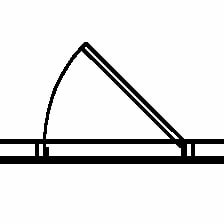

In [7]:
# load query_image from input path
query_image = Image.open('D://Autility//image-similarity//test.jpg')

# resize query image to 224x224 (if required)
query_image = query_image.resize((224, 224), Image.BILINEAR)
# query_image = query_image.rotate(90, Image.NEAREST, expand = 1)

query_image

In [8]:
def get_neighbors(query_image, top_k=30):
    qi_embedding = model(**extractor(query_image, return_tensors="pt"))
    qi_embedding = qi_embedding.last_hidden_state[:, 0].detach().numpy().squeeze()
    scores, retrieved_examples = dataset_with_embeddings.get_nearest_examples('embeddings', qi_embedding, k=top_k)
    return scores, retrieved_examples

In [9]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [ ]:
scores, retrieved_examples = get_neighbors(query_image)
images = [query_image]
images.extend(retrieved_examples["image"])

print(scores)
image_grid(images, 1, len(images))

In [20]:
print(retrieved_examples['image'])

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x1E3AD47A220>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x1E3AD47A190>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x1E3AD439C10>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x1E3AD439640>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x1E3AD439460>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x1E3AD439CA0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x1E3AD439E50>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x1E3AD4398B0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x1E3AD439670>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x1E3AD439400>]


In [138]:
# print names of retrieved images
names = np.array(retrieved_examples['name'])
coords = np.array(retrieved_examples['coords'])
print(coords)
## Logic for finding the majority label: Select the label that occurs the most number of times and if there is a tie, select the first one with higher similarity score




[[[1680 1568]
  [1904 1568]
  [1904 1792]
  [1680 1792]]

 [[1568 1232]
  [1792 1232]
  [1792 1456]
  [1568 1456]]

 [[1568 1568]
  [1792 1568]
  [1792 1792]
  [1568 1792]]

 [[1680 1680]
  [1904 1680]
  [1904 1904]
  [1680 1904]]

 [[1568 1344]
  [1792 1344]
  [1792 1568]
  [1568 1568]]

 [[2352 2240]
  [2576 2240]
  [2576 2464]
  [2352 2464]]

 [[1792 2128]
  [2016 2128]
  [2016 2352]
  [1792 2352]]

 [[2352 2128]
  [2576 2128]
  [2576 2352]
  [2352 2352]]

 [[2128 2688]
  [2352 2688]
  [2352 2912]
  [2128 2912]]

 [[1792 1568]
  [2016 1568]
  [2016 1792]
  [1792 1792]]

 [[3360 2576]
  [3584 2576]
  [3584 2800]
  [3360 2800]]

 [[1232 2016]
  [1456 2016]
  [1456 2240]
  [1232 2240]]

 [[1568 1680]
  [1792 1680]
  [1792 1904]
  [1568 1904]]

 [[1008 1568]
  [1232 1568]
  [1232 1792]
  [1008 1792]]

 [[1008 2240]
  [1232 2240]
  [1232 2464]
  [1008 2464]]

 [[2352 2352]
  [2576 2352]
  [2576 2576]
  [2352 2576]]

 [[1792 1680]
  [2016 1680]
  [2016 1904]
  [1792 1904]]

 [[3360 2464]


In [129]:
import cv2

In [139]:
img = cv2.imread("D:\Autility\image-similarity\Plan2.png")

for coord in coords:
    x, y = coord[0]
    x2, y2 = coord[2]
    cv2.rectangle(img, (x, y), (x2, y2), (0,0,255), 2)
    
cv2.imwrite('similar.jpg', img)

True